In [1]:
import pyspark
import dxpy
import hail as hl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

WD='/opt/notebooks'

In [2]:
my_database = dxpy.find_one_data_object(
    name="my_database", 
    project=dxpy.find_one_project()["id"]
)["id"]
database_dir = f'dnax://{my_database}'
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)
hl.init(sc=sc, tmp_dir=f'{database_dir}/tmp/')

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 2.4.4
SparkUI available at http://ip-10-60-33-28.eu-west-2.compute.internal:8081
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.78-b17627756568
LOGGING: writing to /opt/notebooks/hail-20220823-1518-0.2.78-b17627756568.log


## S0. Load data, functions

In [3]:
tranches = ['250k', '150k', '50k']

fields_to_filter = [
    'n_deletion',
    'n_insertion',
    'n_snp', 
    'r_insertion_deletion',
    'r_ti_tv',
    'r_het_hom_var'
]

# List of metrics that can be aggregated by summing
additive_metrics = [
        "n_called",
        "n_not_called",
        "n_filtered",
        "n_hom_ref",
        "n_het",
        "n_hom_var",
        "n_snp",
        "n_insertion",
        "n_deletion",
        "n_singleton",
        "n_transition",
        "n_transversion",
        "n_star",
    ]

# List of metrics that are ratio of summed metrics (name, numerator, denominator)
ratio_metrics = [
    ("call_rate", "n_called", "n_not_called"),
    ("r_ti_tv", "n_transition", "n_transversion"),
    ("r_het_hom_var", "n_het", "n_hom_var"),
    ("r_insertion_deletion", "n_insertion", "n_deletion"),
]

def get_sample_qc_fname(chrom):
    return f'sample_qc_c{chrom}.v2.0.tsv.gz'

def get_single_chrom_sample_qc_stats(chrom):
    return pd.read_csv(
        f'file:///mnt/project/data/02_hail_sample_qc/{get_sample_qc_fname(chrom)}',
        compression='gzip',
        sep='\t',
        dtype={'s':str}
    )

def get_multi_chrom_qc_stats(chrom_list):
    # TODO: Clean this up, make it more efficient

    qc_stats_list = []

    # Read first table of QC stats
    # Keep only sample ID and additive metrics
    qc_stats = get_single_chrom_sample_qc_stats(chrom_list[0])
    qc_stats = qc_stats[['s']+additive_metrics]


    for chrom in chrom_list[1:]:
        tmp_qc_stats = get_single_chrom_sample_qc_stats(chrom)

        # Keep only sample ID and additive metrics
        tmp_qc_stats = tmp_qc_stats[['s']+additive_metrics]

        # Add chromosome tag so that column names for each chromosome are unique
        tmp_qc_stats = tmp_qc_stats.rename(
            columns={
                field: f'{field}_tmp' for field in tmp_qc_stats.columns if field!='s'
            }
        )
        qc_stats = qc_stats.merge(tmp_qc_stats, on='s')
        for field in additive_metrics:
            qc_stats[field] = qc_stats[field]+qc_stats[f'{field}_tmp']
            qc_stats = qc_stats.drop(columns=f'{field}_tmp')
            
    for field, numer, denom in ratio_metrics:
        # The only field to not strictly use numerators and denominators is "call_rate"
        if field=='call_rate':
            qc_stats[field] = qc_stats[numer]/(qc_stats[numer]+qc_stats[denom])
        else:
            # Calculate ratio metric by dividing numerator field by denominator
            qc_stats[field] = qc_stats[numer]/qc_stats[denom]
            
    return qc_stats

def get_rf_population_assignments():
    # Annotate samples with superpopulation assignments from random forest classification
    pops = pd.read_csv(
        'file:///mnt/project/data/superpopulation_labels.tsv',
        sep='\t',
        usecols=[0,1,2,13,14],
        dtype={
            'sample.ID':str,
            'super.population':str,
            'population':str
        }
    )

    pops = pops.rename(columns={'sample.ID':'s'})
    
    return pops

def annotate_with_tranche(df):
    # Annotate samples with tranche (50k, 150k, 250k)
    samples_50k = pd.read_csv('/mnt/project/resources/ukb12788_wes_50k.sample_ids.txt', delim_whitespace=True, header=None, names=['eid_12788'], dtype=str)
    samples_150k = pd.read_csv('/mnt/project/resources/ukb12788_wes_150k.sample_ids.txt', delim_whitespace=True, header=None, names=['eid_12788'], dtype=str)
    sample_id_map = pd.read_csv('/mnt/project/resources/ukb11867_to_ukb12788.sample_ids.txt', delim_whitespace=True, dtype=str)

    samples_50k = samples_50k.merge(sample_id_map, on='eid_12788')
    samples_150k = samples_150k.merge(sample_id_map, on='eid_12788')

    df['is_in_wes_50k'] = df.s.isin(samples_50k.eid_11867)
    df['is_in_wes_150k'] = df.s.isin(samples_150k.eid_11867)

    df['is_in_wes_250k'] = (df['is_in_wes_50k']==False) & (df['is_in_wes_150k']==False)
    
    return df

def get_qc_stats_with_pop_and_tranche(chrom_list):
    qc_stats = get_multi_chrom_qc_stats(chrom_list)

    # Read population assignments
    pops = get_rf_population_assignments()

    # Merge QC stats with population assignments
    qc_stats = qc_stats.merge(pops.iloc[:,:3], on='s')

    superpops = qc_stats['classification_strict'].value_counts().index

    qc_stats = annotate_with_tranche(qc_stats)
    
    return qc_stats, superpops

def get_bins(series, n_bins=100):
    if np.array_equal(series, series.astype(int)):
        step = 1
        n_steps = series.max()-series.min()
        while n_steps>100:
            n_steps /= 2
            step *= 2
        bins = np.arange(series.min(), series.max(), step=step)-0.5
    else:
        _, bins = np.histogram(series, n_bins)
        
    return bins

def save_fig(fname, out_folder, skip_dx_upload=False):
    plt.savefig(f'{WD}/{fname}', dpi=300)
    
    if not skip_dx_upload:
        dxpy.upload_local_file(
            filename=f'/opt/notebooks/{fname}',
            name=fname,
            folder=out_folder,
            parents=True
        )

def save_dataframe_as_tsv_gz(df, fname, out_folder):
    df.to_csv(f'/opt/notebooks/{fname}', compression='gzip', index=False, sep='\t')
    
    dxpy.upload_local_file(
            filename=f'/opt/notebooks/{fname}',
            name=fname,
            folder=out_folder,
            parents=True
        )
        
def mad_filter(df, n_mads, fields_to_filter = ['n_deletion','n_insertion','n_snp', 'r_insertion_deletion','r_ti_tv','r_het_hom_var'], classification = 'strict', print_final_ct_only=False):
    print(f'** {version} **')
    print(f'** n_mads = {n_mads} **')
    print(f'** classification = {classification} **\n')
    if classification=='strict':
        is_unsure = df[f'classification_strict']=='unsure'
        df = df[~is_unsure].copy()
        print(f'* Removed superpop="unsure" individuals: {is_unsure.sum()}\n')
    fail_cols_list = [f"fail_{n_mads}mad_{field}" for field in fields_to_filter]
    for tranche in tranches:
        for pop in superpops:
            if pop=='unsure': continue
            is_subgroup = (df[f'classification_{classification}']==pop)&(df[f'is_in_wes_{tranche}'])
            if not print_final_ct_only: print(tranche, pop, is_subgroup.sum())
            for field in fields_to_filter:
                fail_col = f'fail_{n_mads}mad_{field}'
                median = np.median(df.loc[is_subgroup, field])
                mad = stats.median_abs_deviation(df.loc[is_subgroup, field])
                is_fail = (df[field] < median - n_mads*mad) | (df[field] > median + n_mads*mad)
                df.loc[is_subgroup, fail_col] = False
                df.loc[is_subgroup & is_fail, fail_col] = True
                if not print_final_ct_only: print(f' - fail {field}: {int(df.loc[is_subgroup & is_fail, fail_col].sum())}')
            subgroup = df.loc[is_subgroup, fail_cols_list]
            if not print_final_ct_only: print(f' * total fail: {(subgroup.sum(axis=1)>0).sum()}')
    df['pass'] = df[fail_cols_list].sum(axis=1)==0
    print(f'\n** total failed: {(df["pass"]==False).sum()} **')
    print(f'** total pass: {df["pass"].sum()} **')
    for pop in superpops:
        if pop=='unsure': continue
        print(f' * {pop} pass: {((df[f"classification_{classification}"]==pop)&df["pass"]).sum()}')
    return df

def get_mad_threshold_tsv_fname(n_mads, classification):
    return f'ukb_wes_450k.mad_threshold.nmad_{n_mads}.popclass_{classification}.tsv.gz'

In [4]:
chrom_list = list(range(1,23))
qc_stats, superpops = get_qc_stats_with_pop_and_tranche(chrom_list)

assert qc_stats.shape==(454230, 23), 'we expect the qc stats table for prefilter v2.0 to have 454198 samples, 23 columns'

In [7]:
qc_stats

,s,n_called,n_not_called,n_filtered,n_hom_ref,n_het,n_hom_var,n_snp,n_insertion,n_deletion,...,n_star,call_rate,r_ti_tv,r_het_hom_var,r_insertion_deletion,classification_strict,classification_loose,is_in_wes_50k,is_in_wes_150k,is_in_wes_250k
0,1000010,19576470,122258,0,19534500,26746,15224,53751,1806,1637,...,0,0.993794,2.544645,1.756831,1.103238,EUR,EUR,False,False,True
1,1000028,19525982,172746,0,19484225,26303,15454,53853,1800,1558,...,0,0.991231,2.554419,1.702019,1.155327,EUR,EUR,True,False,False
2,1000034,19553655,145073,0,19511405,26510,15740,54592,1842,1556,...,0,0.992635,2.538043,1.684244,1.183805,EUR,EUR,False,True,False
3,1000045,19565925,132803,0,19524185,26208,15532,53810,1864,1598,...,0,0.993258,2.497335,1.687355,1.166458,EUR,EUR,False,False,True
4,1000052,19575451,123277,0,19533230,26573,15648,54381,1874,1614,...,0,0.993742,2.488869,1.698172,1.161090,EUR,EUR,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454225,6026378,19594823,103905,0,19553274,25985,15564,53717,1810,1586,...,0,0.994725,2.509080,1.669558,1.141236,EUR,EUR,False,False,True
454226,6026383,19593106,105622,0,19551829,25872,15405,53295,1775,1612,...,0,0.994638,2.592033,1.679455,1.101117,EUR,EUR,False,True,False
454227,6026397,19532424,166304,0,19490857,25580,15987,54131,1811,1612,...,0,0.991558,2.512719,1.600050,1.123449,EUR,EUR,True,False,False
454228,6026401,19592545,106183,0,19550515,26346,15684,54213,1850,1651,...,0,0.994610,2.543102,1.679801,1.120533,EUR,EUR,False,True,False


## S1. Plot QC metrics

### Set up parameters

In [5]:
version = 'prefilter_v2.0'

cols_to_plot = [c for c in qc_stats.columns if (
    ('n_' in c)
    |('.mean' in c)
    |('r_' in c)
    |(c=='call_rate')
) & (
    (c!='n_not_called')
    &(c!='n_star')
    &((c!='n_filtered') if version=='prefilter_v2.0' else True) # Skip n_filtered if prefilter version v2.0 (it's a useless field when no genotype filters are performed)
) & (
    (c in additive_metrics)
    | (c in [r for r,_,_ in ratio_metrics]) 
)]

subplots_kwargs = dict(
    nrows=4,
    ncols=4,
    figsize=(24,16)
)

suptitle_kwargs = dict(
    y=0.93,
    size=15
)

# Cloud directory for plots to be output
out_folder = '/plots/03_mad_threshold/'

### S1a. No stratification

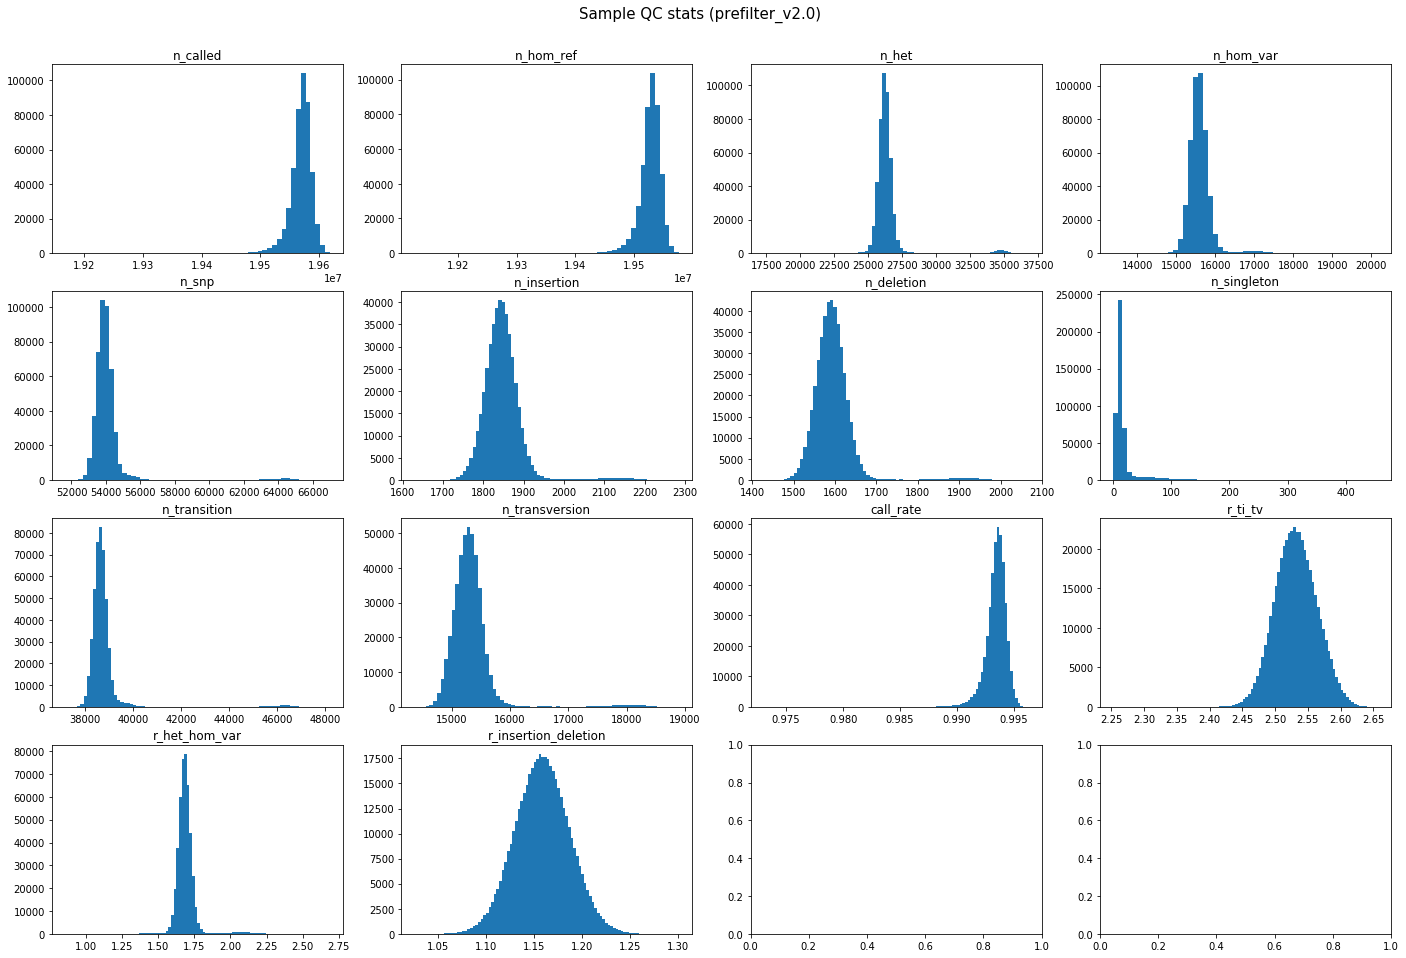

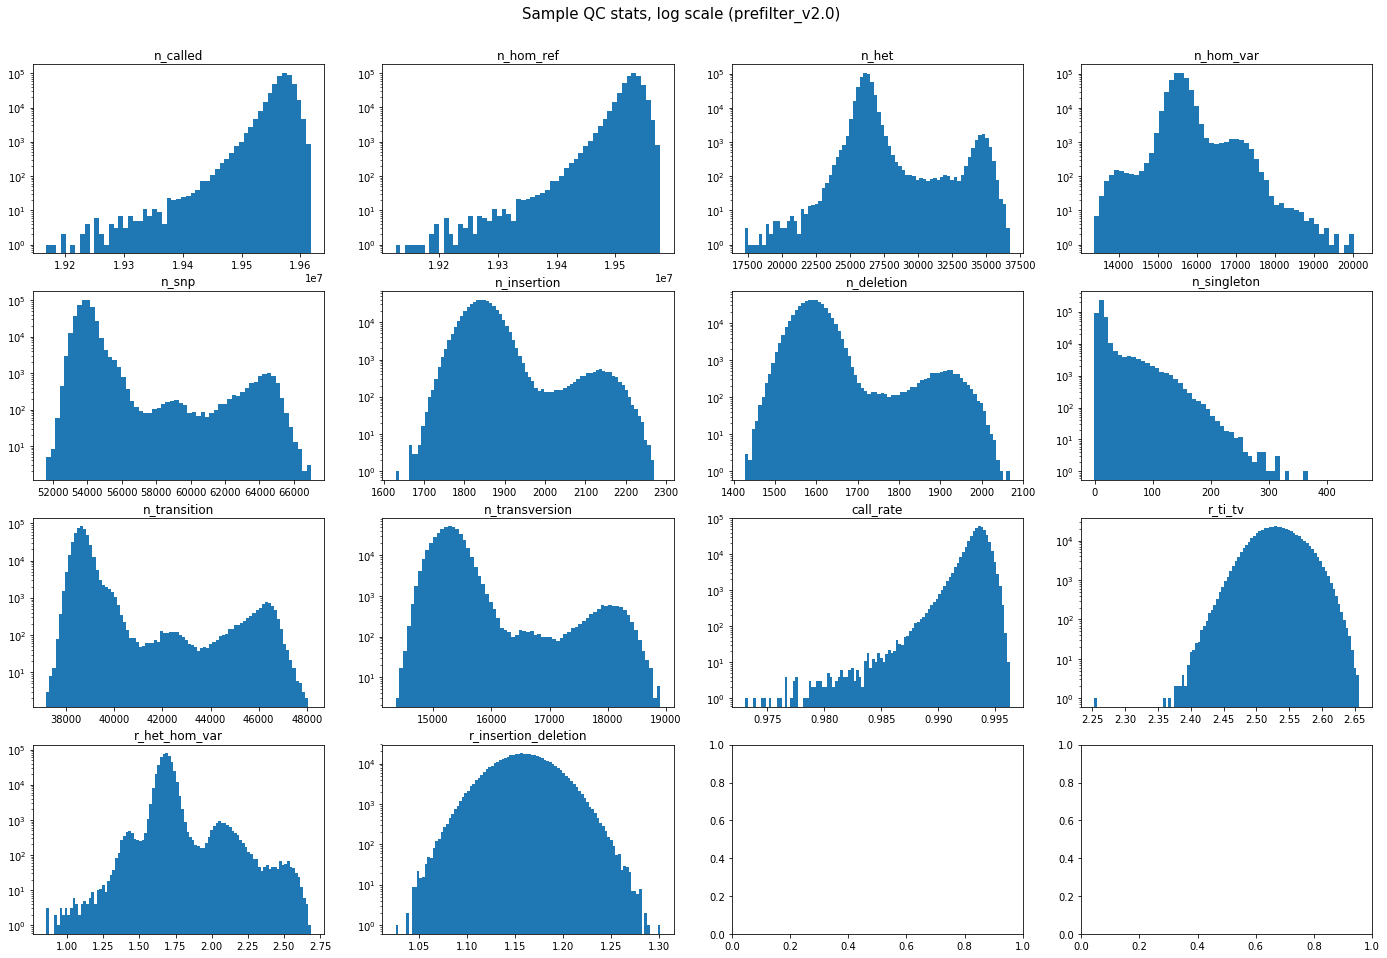

In [9]:
for logscale in [False, True]:
    fig, axs = plt.subplots(**subplots_kwargs)
    for idx, col in enumerate(cols_to_plot):
        ax = axs[idx//subplots_kwargs['nrows']][idx%subplots_kwargs['ncols']]
        ax.set_title(col)
        try:
            bins = get_bins(qc_stats[col])
            ax.hist(qc_stats[col], bins=bins)
            if logscale: ax.set_yscale('log')
        except: pass
    plt.suptitle(f'Sample QC stats{", log scale" if logscale else ""} ({version})', **suptitle_kwargs)
    save_fig(fname=f'ukb_wes_450k.{version}.sample_qc{".logscale" if logscale else ""}.png', out_folder=out_folder)


### S1b. Stratify by population

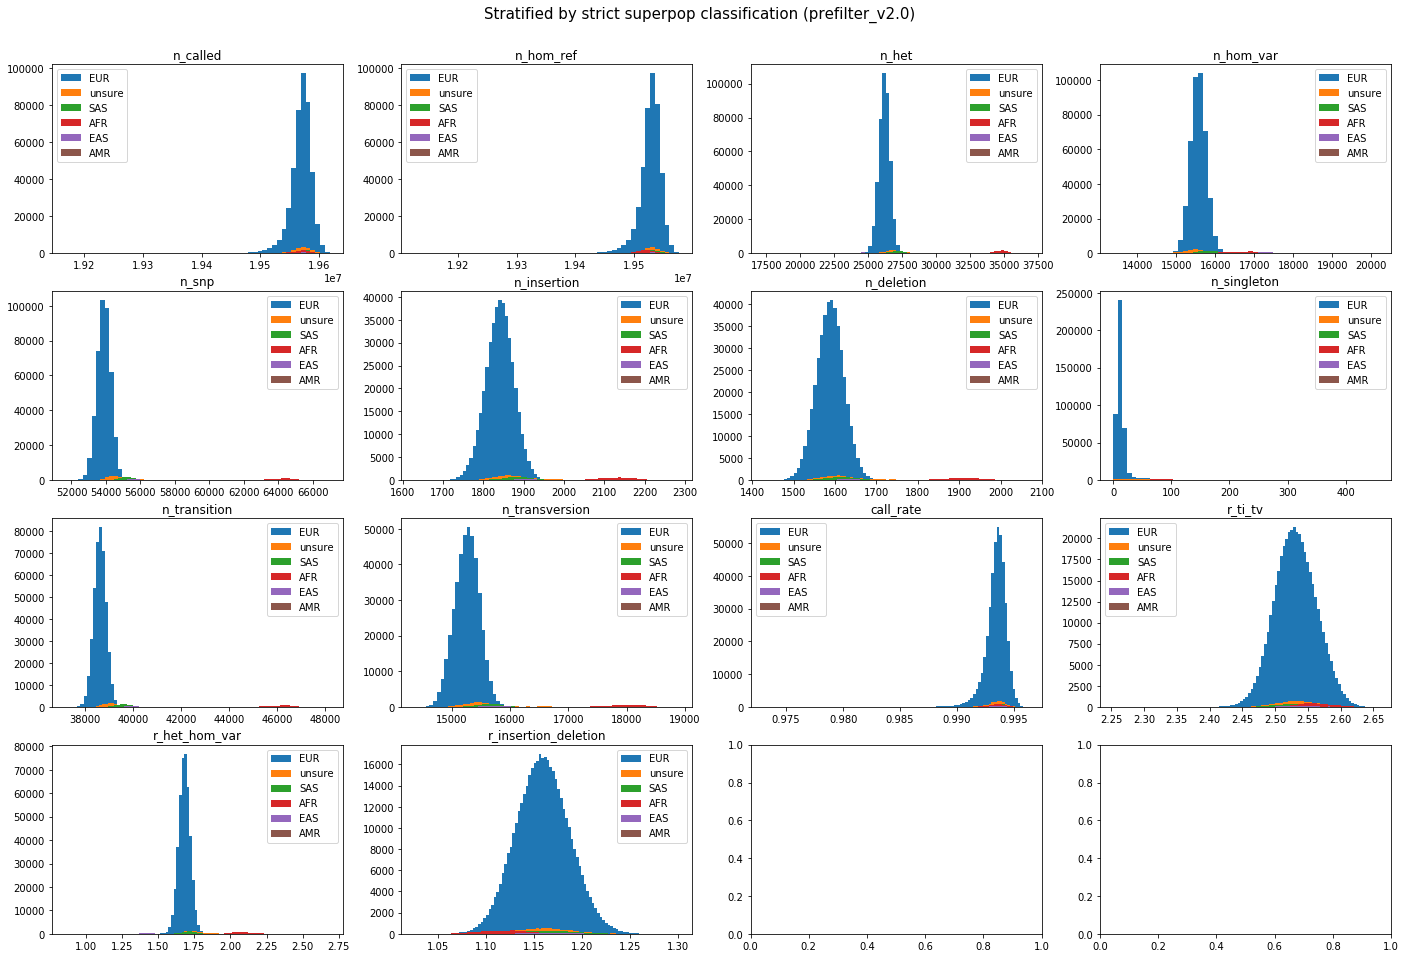

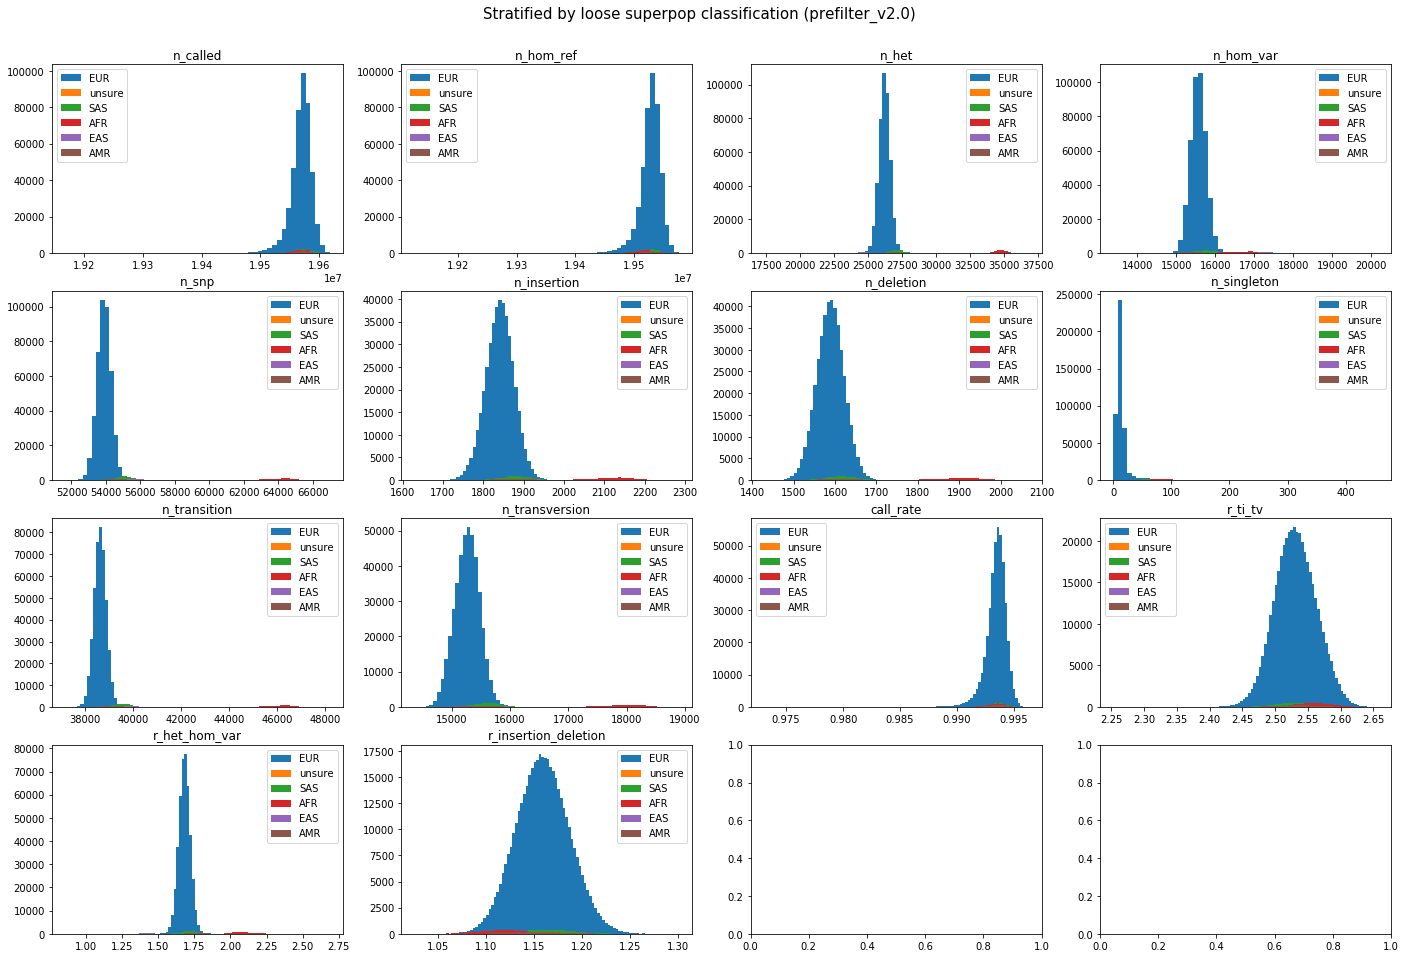

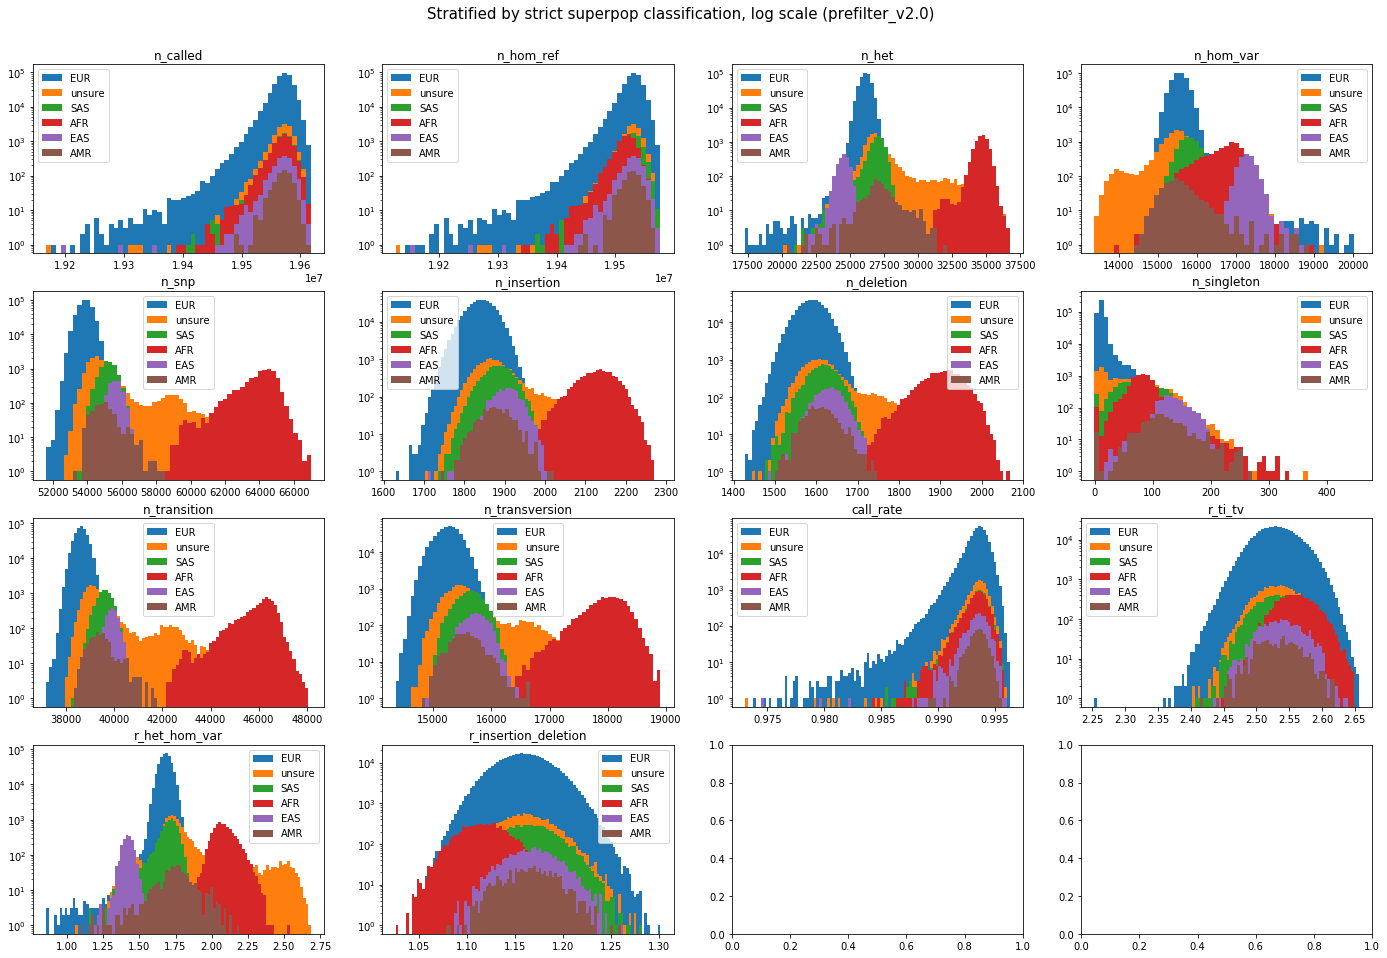

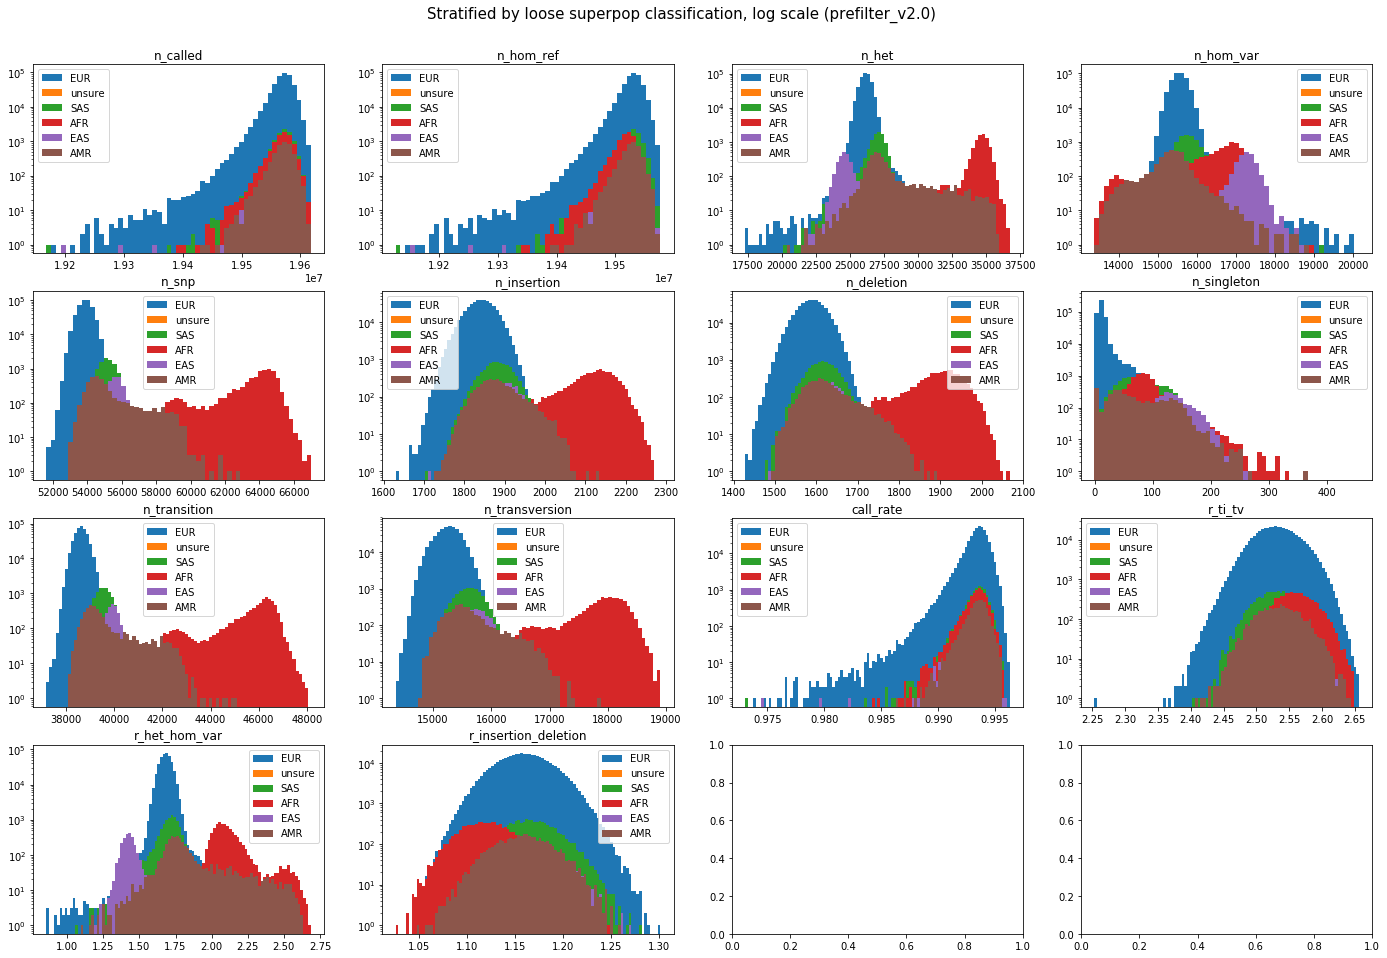

In [10]:
for logscale in [False, True]:
    for clasification in ['strict', 'loose']:

        fig, axs = plt.subplots(**subplots_kwargs)
        for idx, col in enumerate(cols_to_plot):
            ax = axs[idx//subplots_kwargs['nrows']][idx%subplots_kwargs['ncols']]
            ax.set_title(col)
            try:
                bins = get_bins(qc_stats[col])
                for pop in superpops:
                    ax.hist(qc_stats.loc[qc_stats[f'classification_{clasification}']==pop, col], bins=bins, label=pop)
                    if logscale:
                        ax.set_yscale('log')
                ax.legend()
            except:
                print(col)
        plt.suptitle(f'Stratified by {clasification} superpop classification{", log scale" if logscale else ""} ({version})', **suptitle_kwargs)
        save_fig(fname=f'ukb_wes_450k.{version}.sample_qc.strat_by_{clasification}_superpop{".logscale" if logscale else ""}.png', out_folder=out_folder)

### S1c. Stratify by tranche

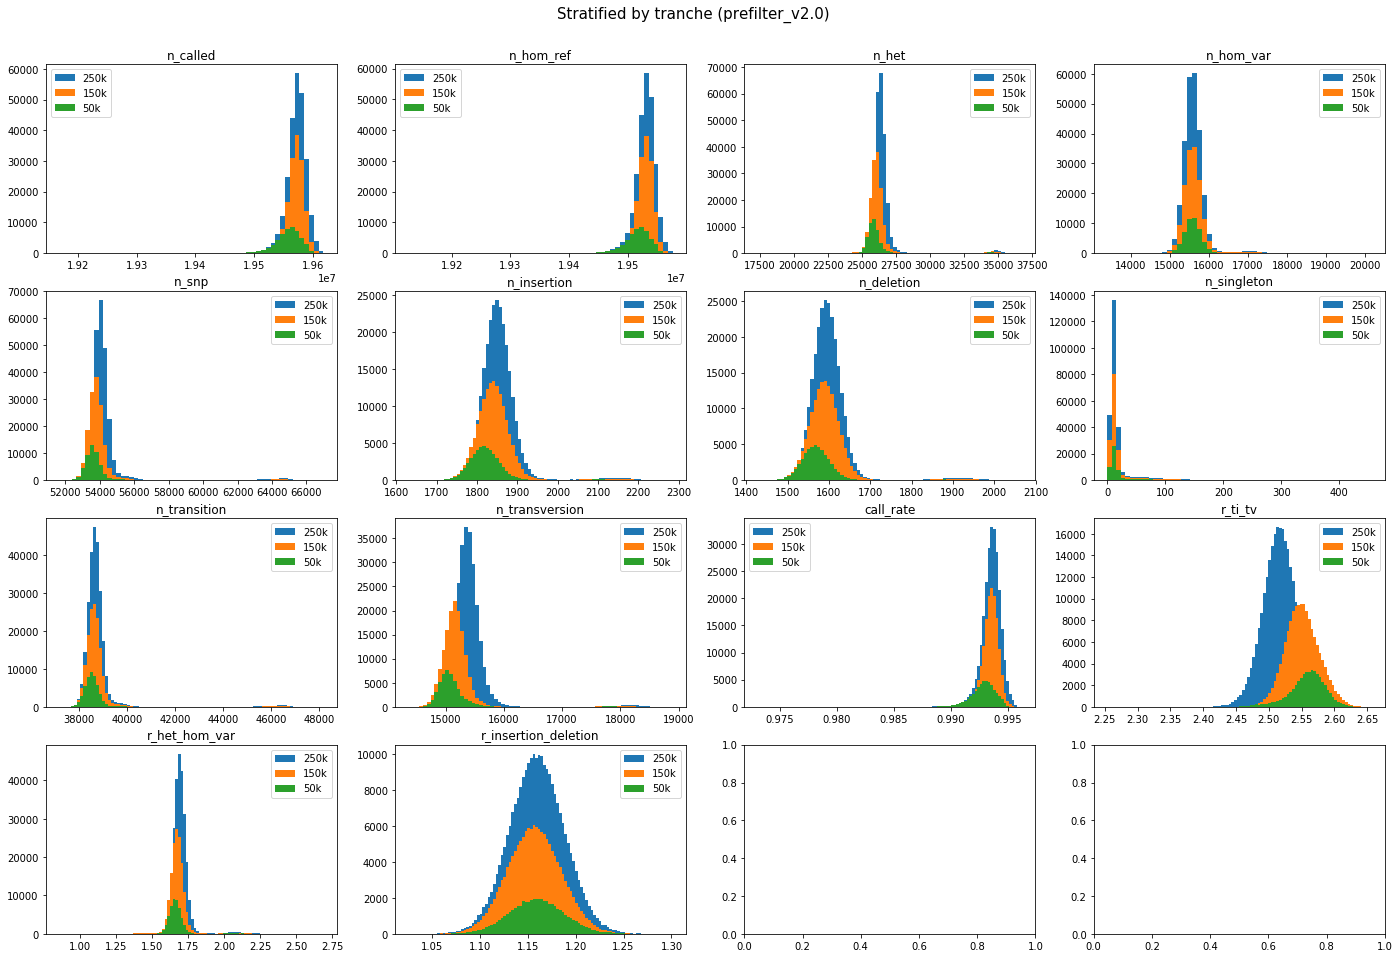

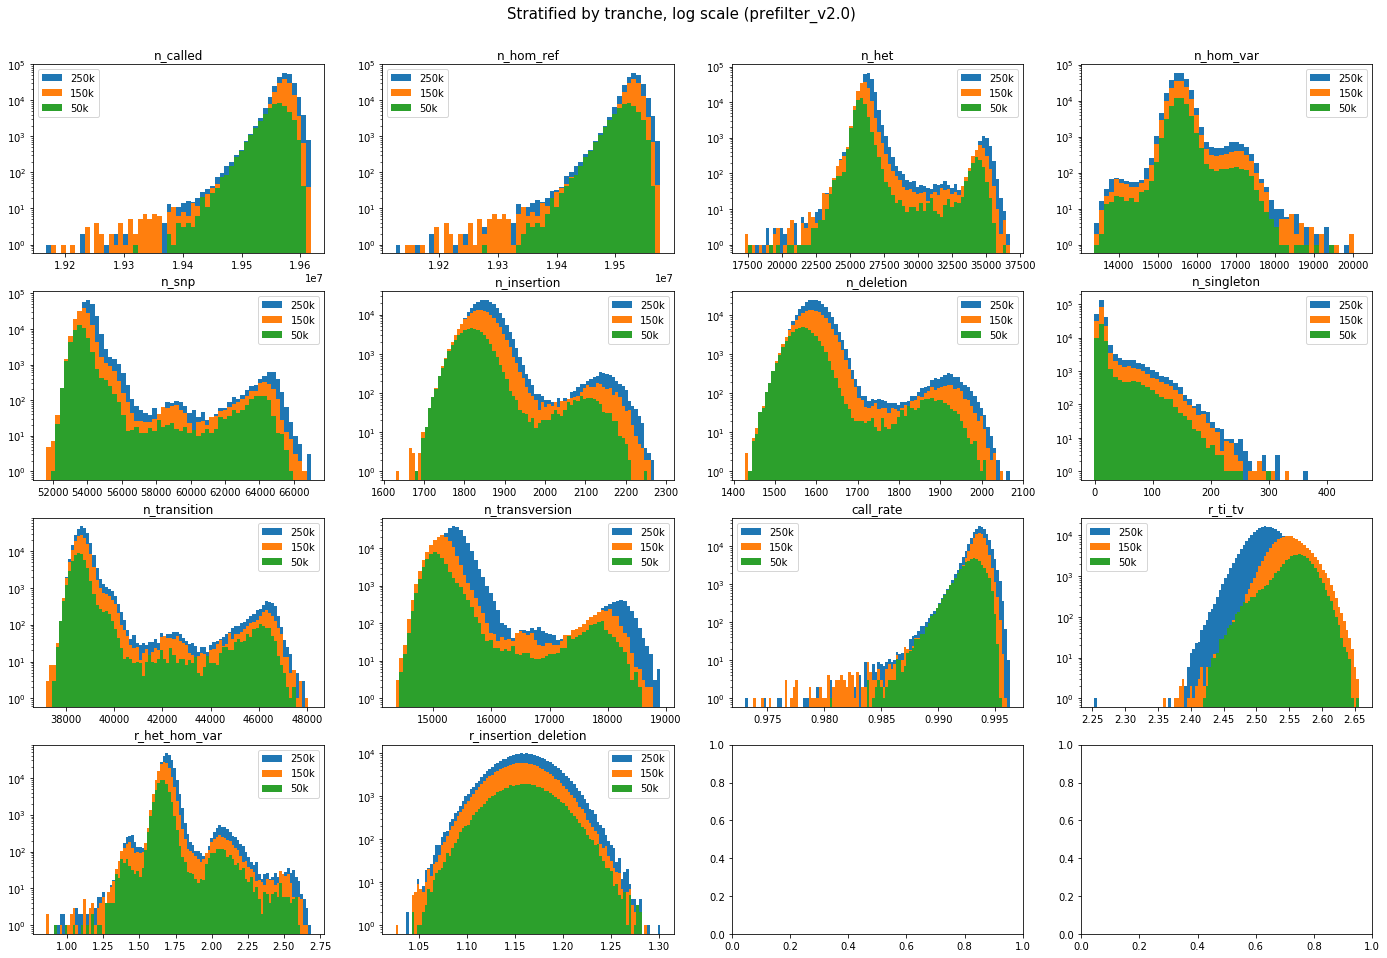

In [11]:
for logscale in [False, True]:
    fig, axs = plt.subplots(**subplots_kwargs)
    for idx, col in enumerate(cols_to_plot):
        bins = get_bins(qc_stats[col])
        ax = axs[idx//subplots_kwargs['nrows']][idx%subplots_kwargs['ncols']]
        ax.set_title(col)
        try:
            for tranche in tranches:
                ax.hist(qc_stats.loc[qc_stats[f'is_in_wes_{tranche}']==True, col], bins=bins, label=tranche)
            if logscale:
                ax.set_yscale('log')
            ax.legend()
        except: pass
    plt.suptitle(f'Stratified by tranche{", log scale" if logscale else ""} ({version})', y=0.93, size=15)
    save_fig(fname=f'ukb_wes_450k.{version}.sample_qc.strat_by_tranche{".logscale" if logscale else ""}.png', out_folder=out_folder)

#### S1ci. Stratify by tranche (European only)

In [ ]:
# classification='strict'

# for logscale in [False, True]:
#     fig, axs = plt.subplots(**subplots_kwargs)
#     for idx, col in enumerate(cols_to_plot):
#         bins = get_bins(qc_stats[col])
#         ax = axs[idx//subplots_kwargs['nrows']][idx%subplots_kwargs['ncols']]
#         ax.set_title(col)
#         try:
#             for tranche in tranches:
#                 ax.hist(qc_stats.loc[qc_stats[f'is_in_wes_{tranche}']==True, col], bins=bins, label=tranche)
#             if logscale:
#                 ax.set_yscale('log')
#             ax.legend()
#         except: pass
#     plt.suptitle(f'Stratified by tranche{", log scale" if logscale else ""} ({version})', y=0.93, size=15)
#     save_fig(fname=f'ukb_wes_450k.{version}.sample_qc.strat_by_tranche{".logscale" if logscale else ""}.png', out_folder=out_folder)

### S1d. Stratify by population and tranche

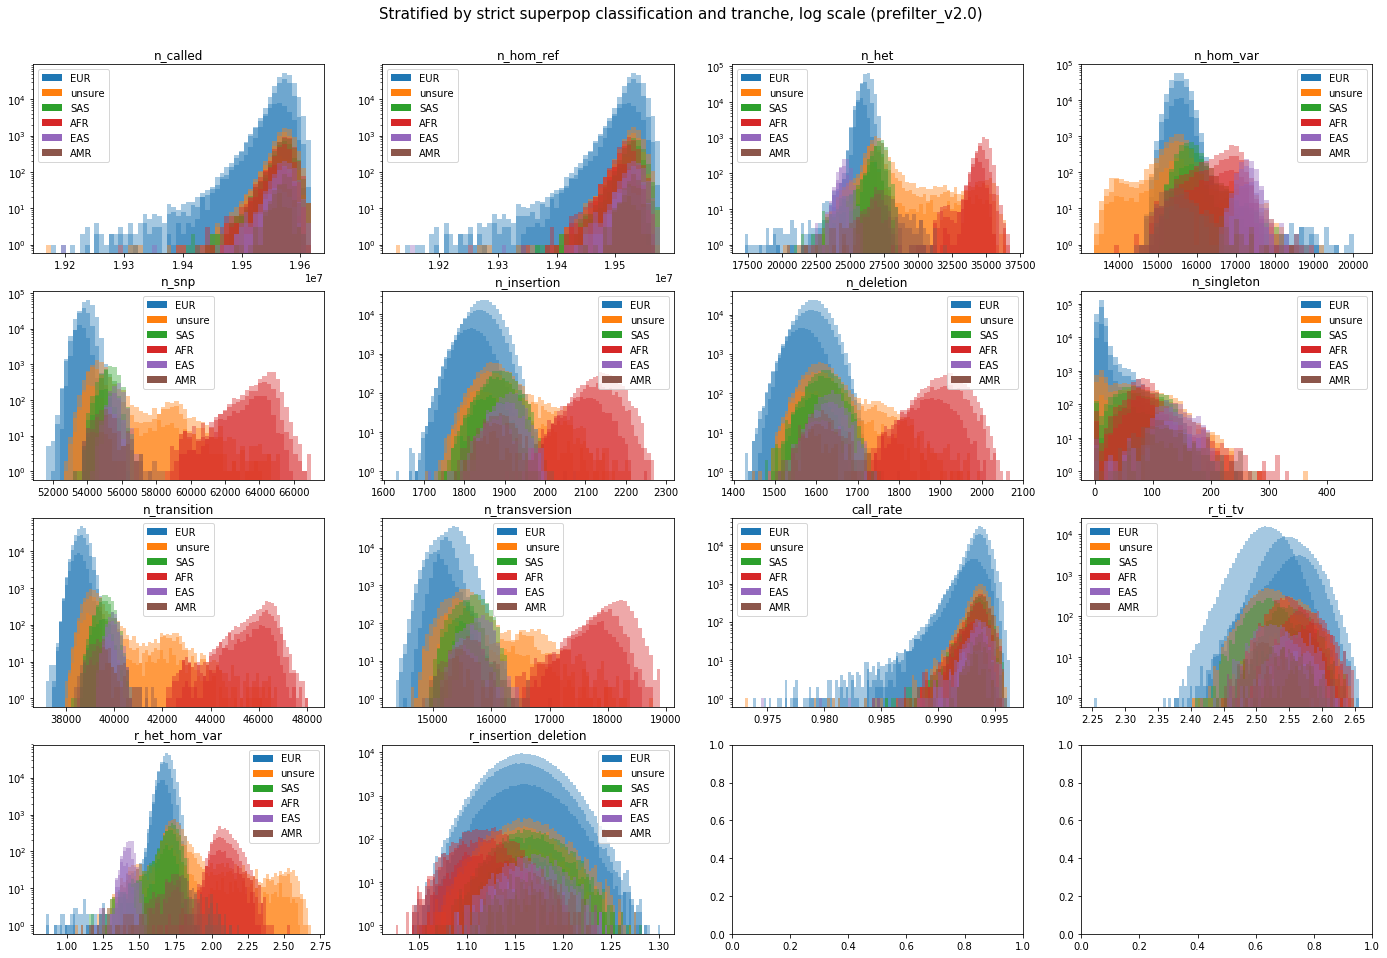

In [12]:
from matplotlib.patches import Patch

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pop_color_dict = dict(zip(superpops, colors))
custom_lines = [Patch(facecolor=c, edgecolor=None,label=pop) for pop, c in pop_color_dict.items()]

for logscale in [False, True]:
    classification='strict'

    fig, axs = plt.subplots(**subplots_kwargs)
    for idx, col in enumerate(cols_to_plot):
        ax = axs[idx//subplots_kwargs['nrows']][idx%subplots_kwargs['ncols']]
        ax.set_title(col)
        try:
            bins = get_bins(qc_stats[col])
            for pop in superpops:
                for tranche in tranches:
                    is_in_tranche = qc_stats[f'is_in_wes_{tranche}']==True
                    is_in_pop = qc_stats[f'classification_{classification}']==pop
                    ax.hist(qc_stats.loc[is_in_tranche&is_in_pop, col], bins=bins, alpha=0.4, color=pop_color_dict[pop])
            if logscale: ax.set_yscale('log')
            ax.legend(handles=custom_lines)
        except:
            print(col)
    plt.suptitle(f'Stratified by {classification} superpop classification and tranche{", log scale" if logscale else ""} ({version})', **suptitle_kwargs)
    save_fig(fname=f'ukb_wes_450k.{version}.sample_qc.strat_by_{classification}_superpop_and_tranche{".logscale" if logscale else ""}.png', out_folder=out_folder)

## S2. MAD threshold

In [6]:
n_mads = 4
classification='strict'

mad4 = mad_filter(
    df = qc_stats,
    n_mads = n_mads,
    classification=classification
)

fname=get_mad_threshold_tsv_fname(n_mads=n_mads, classification=classification)
out_folder='/data/03_mad_threshold'
save_dataframe_as_tsv_gz(df=mad4, fname=fname, out_folder=out_folder)

** prefilter_v2.0 **
** n_mads = 4 **
** classification = strict **

* Removed superpop="unsure" individuals: 13901

250k EUR 237091
 - fail n_deletion: 1510
 - fail n_insertion: 1573
 - fail n_snp: 1856
 - fail r_insertion_deletion: 1741
 - fail r_ti_tv: 2890
 - fail r_het_hom_var: 2301
 * total fail: 10861
250k SAS 3919
 - fail n_deletion: 17
 - fail n_insertion: 32
 - fail n_snp: 22
 - fail r_insertion_deletion: 28
 - fail r_ti_tv: 50
 - fail r_het_hom_var: 241
 * total fail: 367
250k AFR 4121
 - fail n_deletion: 86
 - fail n_insertion: 65
 - fail n_snp: 258
 - fail r_insertion_deletion: 24
 - fail r_ti_tv: 47
 - fail r_het_hom_var: 115
 * total fail: 399
250k EAS 968
 - fail n_deletion: 8
 - fail n_insertion: 6
 - fail n_snp: 9
 - fail r_insertion_deletion: 12
 - fail r_ti_tv: 9
 - fail r_het_hom_var: 23
 * total fail: 58
250k AMR 321
 - fail n_deletion: 8
 - fail n_insertion: 2
 - fail n_snp: 13
 - fail r_insertion_deletion: 5
 - fail r_ti_tv: 1
 - fail r_het_hom_var: 29
 * total 

In [7]:
n_mads = 4
classification='loose'

mad4 = mad_filter(
    df = qc_stats,
    n_mads = n_mads,
    classification=classification
)

fname=f'ukb_wes_450k.mad_threshold.nmad_{n_mads}.popclass_{classification}.tsv.gz'
out_folder='/data/03_mad_threshold'
save_dataframe_as_tsv_gz(df=mad4, fname=fname, out_folder=out_folder)

** prefilter_v2.0 **
** n_mads = 4 **
** classification = loose **

250k EUR 240666
 - fail n_deletion: 1589
 - fail n_insertion: 1676
 - fail n_snp: 2365
 - fail r_insertion_deletion: 1774
 - fail r_ti_tv: 2923
 - fail r_het_hom_var: 2929
 * total fail: 11745
250k SAS 5057
 - fail n_deletion: 41
 - fail n_insertion: 50
 - fail n_snp: 85
 - fail r_insertion_deletion: 35
 - fail r_ti_tv: 67
 - fail r_het_hom_var: 376
 * total fail: 536
250k AFR 4673
 - fail n_deletion: 273
 - fail n_insertion: 223
 - fail n_snp: 608
 - fail r_insertion_deletion: 26
 - fail r_ti_tv: 49
 - fail r_het_hom_var: 344
 * total fail: 721
250k EAS 1266
 - fail n_deletion: 12
 - fail n_insertion: 14
 - fail n_snp: 12
 - fail r_insertion_deletion: 17
 - fail r_ti_tv: 15
 - fail r_het_hom_var: 75
 * total fail: 122
250k AMR 2257
 - fail n_deletion: 96
 - fail n_insertion: 54
 - fail n_snp: 313
 - fail r_insertion_deletion: 23
 - fail r_ti_tv: 15
 - fail r_het_hom_var: 393
 * total fail: 456
150k EUR 141936
 - fail 

In [8]:
for n_mads in [3,5]:
    for classification in ['loose', 'strict']:

        mad = mad_filter(
            df = qc_stats,
            n_mads = n_mads,
            classification=classification,
            print_final_ct_only=True
        )
        print()

        fname=f'ukb_wes_450k.mad_threshold.nmad_{n_mads}.popclass_{classification}.tsv.gz'
        out_folder='/data/03_mad_threshold'
        save_dataframe_as_tsv_gz(df=mad, fname=fname, out_folder=out_folder)

** prefilter_v2.0 **
** n_mads = 3 **
** classification = loose **


** total failed: 101112 **
** total pass: 353118 **
 * EUR pass: 335032
 * SAS pass: 7191
 * AFR pass: 6346
 * EAS pass: 1730
 * AMR pass: 2819

** prefilter_v2.0 **
** n_mads = 3 **
** classification = strict **

* Removed superpop="unsure" individuals: 13901


** total failed: 96269 **
** total pass: 344060 **
 * EUR pass: 331016
 * SAS pass: 5604
 * AFR pass: 5685
 * EAS pass: 1355
 * AMR pass: 400

** prefilter_v2.0 **
** n_mads = 5 **
** classification = loose **


** total failed: 7693 **
** total pass: 446537 **
 * EUR pass: 423950
 * SAS pass: 9232
 * AFR pass: 7529
 * EAS pass: 2251
 * AMR pass: 3575

** prefilter_v2.0 **
** n_mads = 5 **
** classification = strict **

* Removed superpop="unsure" individuals: 13901


** total failed: 4982 **
** total pass: 435347 **
 * EUR pass: 418673
 * SAS pass: 7232
 * AFR pass: 7138
 * EAS pass: 1749
 * AMR pass: 555

